# Alanine Multistate
## Example Simulation

This uses the state definition from [1]. 6 states named A,B,C,D,E and F

[1] W.-N. Du, K. A. Marino, and P. G. Bolhuis, “Multiple state transition interface sampling of alanine dipeptide in explicit solvent,” J. Chem. Phys., vol. 135, no. 14, p. 145102, 2011.

Import Modules

In [1]:
import numpy as np
import mdtraj as md
import pandas as pd
import time
import sys, os
import math
import random

import openpathsampling as paths

from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as unit

from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

import openpathsampling.engines.openmm as peng

In [2]:
# Imports for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.legend_handler import HandlerLine2D

Create an AlanineOpenMMSimulator for demonstration purposes

### Set simulation options and create a simulator object

Set the regular simulation parameters

In [3]:
template = peng.snapshot_from_pdb("../data/Alanine_solvated.pdb")

In [4]:
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')

omm_topology = peng.to_openmm_topology(template)

system = forcefield.createSystem(omm_topology, nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds, 
    rigidWater=True, ewaldErrorTolerance=0.0005)
integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
integrator.setConstraintTolerance(0.00001)

platform = mm.Platform.getPlatformByName('OpenCL')
properties = {'OpenCLPrecision': 'mixed'}

In [5]:
engine_options = {
    'n_frames_max': 500,
    'platform': 'OpenCL',
    'nsteps_per_frame': 10
}

In [6]:
engine = peng.Engine(
    template, 
    system, 
    integrator, 
    properties=properties,
    options=engine_options
)
engine.name = 'default'

Set a high temperature simulation for exploration.

In [7]:
integrator_high = mm.LangevinIntegrator(1000*unit.kelvin, 1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
integrator_high.setConstraintTolerance(0.00001)

In [8]:
engine_high = engine.from_new_options(integrator=integrator_high)
engine_high.name = 'high'

In [9]:
paths.EngineMover.engine = engine

In [10]:
storage = paths.Storage("ala.nc", mode='w', template=template)

In [11]:
print storage.save(engine)
print storage.save(engine_high)

(store.engines[DynamicsEngine], 11, 0)
(store.engines[DynamicsEngine], 11, 1)


And save the storage in a separate variable for convenience

In [12]:
platform = engine.simulation.context.getPlatform()
print platform.getName()

OpenCL


Equilibrate

In [13]:
engine.current_snapshot = engine.template
engine.minimize()
engine_high.current_snapshot = engine.template
engine_high.minimize()

Save equilibrated snapshots

In [14]:
initial_snapshot_low = engine.current_snapshot
initial_snapshot_high = engine_high.current_snapshot

In [15]:
storage.save(engine.current_snapshot);
storage.save(engine_high.current_snapshot);

In [16]:
storage.tag['low_template'] = engine.current_snapshot
storage.tag['high_template'] = engine_high.current_snapshot

### State Definitions

We define states A-F and $\alpha$ and $\beta$ although we will use the 6 state definition mostly.

In [17]:
states = ['A', 'B', 'C', 'D', 'E', 'F']

In [18]:
state_letter = {
    'A' : 'A',
    'B' : 'B',
    'C' : 'C',
    'D' : 'D',
    'E' : 'E',
    'F' : 'F',
    'alpha' : u'α',
    'beta' : u'β'
}

In [19]:
state_centers = {
    'A' : [-150, 150], 
    'B' : [-70, 135], 
    'C' : [-150, -65], 
    'D' : [-70, -50], 
    'E' : [50, -100], 
    'F' : [40, 65]
}

In [20]:
interface_levels = {
    'A' : [10, 20, 45, 65, 80],
    'B' : [10, 20, 45, 65, 75],
    'C' : [10, 20, 45, 60],
    'D' : [10, 20, 45, 60],
    'E' : [10, 20, 45, 65, 80],
    'F' : [10, 20, 45, 65, 80],
    'alpha' : [10, 20, 45, 55, 65, 75],
    'beta' : [10, 20, 40, 45, 50, 60],    
}

In [21]:
storage.tag['states'] = states
storage.tag['state_centers'] = state_centers
storage.tag['state_letter'] = state_letter
storage.tag['interface_levels'] = interface_levels

### Order Parameters

this generates an order parameter (callable) object named psi (so if we call `psi(trajectory)` we get a list of the values of psi for each frame in the trajectory). This particular order parameter uses mdtraj's compute_dihedrals function, with the atoms in psi_atoms

In [22]:
psi_atoms = [6,8,14,16]
psi = paths.CV_MDTraj_Function("psi", md.compute_dihedrals,
                  indices=[psi_atoms])

phi_atoms = [4,6,8,14]
phi = paths.CV_MDTraj_Function("phi", md.compute_dihedrals,
                  indices=[phi_atoms])

storage.save([psi, phi]);

Define a function that defines a distance in periodic $\phi,\psi$-space.

In [23]:
def circle_degree(snapshot, center, phi, psi):
    import math
    degrees = 180/3.14159    
    psi_deg = psi(snapshot) * degrees
    phi_deg = phi(snapshot) * degrees
    return math.sqrt(
            ( min( phi_deg - center[0], 360 - phi_deg + center[0])**2 + 
              min( psi_deg - center[1], 360 - psi_deg + center[1])**2)
             )

Create CVs for all states

In [24]:
cv_state = dict()
for state in state_centers:
    op = paths.CV_Function(
        name = 'op' + state,
        f=circle_degree,
        center=state_centers[state],
        psi=psi,
        phi=phi
    )
    cv_state[state] = op

In [25]:
print storage.save(cv_state.values())

[(store.cvs[CollectiveVariable], 6, 2), (store.cvs[CollectiveVariable], 6, 3), (store.cvs[CollectiveVariable], 6, 4), (store.cvs[CollectiveVariable], 6, 5), (store.cvs[CollectiveVariable], 6, 6), (store.cvs[CollectiveVariable], 6, 7)]


### Volumes

Create Interfaces

In [26]:
interface_list = {}
for state in interface_levels:
    levels = interface_levels[state]
    interface_list[state] = [None] * len(levels)
    for idx, level in enumerate(levels):
        if state == 'alpha':
            interface_list[state][idx] = \
                paths.CVRangeVolume(cv_state['A'], lambda_max=level) | \
                paths.CVRangeVolume(cv_state['B'], lambda_max=level)
        elif state == 'beta':
            interface_list[state][idx] = \
                paths.CVRangeVolume(cv_state['C'], lambda_max=level) | \
                paths.CVRangeVolume(cv_state['D'], lambda_max=level)
        else:
            interface_list[state][idx] = \
                paths.CVRangeVolume(cv_state[state], lambda_max=level)

        interface_list[state][idx].name = state + str(idx)

Create `Volume` objects for all states. The state definition is actually the lowest interface which means that Interface 0 are all trajectories that leave a state and return or hit another core.

In [27]:
vol_state = {state : interface_list[state][0] for state in interface_list}

In [28]:
stAll = reduce(lambda x, y: x | y, [vol_state[state] for state in states])
stAll.name = 'all'
storage.save(stAll)

(store.volumes[Volume], 16, 0)

### Utility functions

Define a few functions that simplify analysis and progress report.

#### Information

In [29]:
def get_state(snapshot):
    for state in states:
        if interface_list[state][-1](snapshot):
            return state

    return '-'

def get_core(snapshot):
    for state in states:
        if interface_list[state][0](snapshot):
            return state

    return '-'

def get_interface(snapshot):
    for state in states:
        for idx, interface in enumerate(interface_list[state]):
            if interface(snapshot):
                return state, idx

    return '-', 0

In [30]:
def state_information(snapshot):
    for state in states:
        cv = cv_state[state]
        print '%s: %7.2f' % (state, cv(snapshot)),
        for idx, interface in enumerate(interface_list[state]):
            if interface(snapshot):
                print '+',
                current_state = state
            else:
                print '-',

        print    

    print 'The initial configuration is in state', current_state

#### Trajectory Plotting

In [31]:
%config InlineBackend.figure_format='retina'

def plot_main():
    plt.figure(figsize=(8, 8))
    rect = plt.Rectangle((-180,-180),360,360, facecolor="none", edgecolor="none")    
    
    plt.xlim(-180, 180);
    plt.ylim(-180, 180);    
    
    centers = state_centers.values()

    plt.plot([x[0] for x in centers], [x[1] for x in centers], 'ko')

    fig = plt.gcf()

    for level in range(100,0,-1):
        for col in [True, False]:
            for name, center in state_centers.iteritems():
                if level == 1:
                    plt.annotate(name, xy=center, xytext=(center[0]+10 + 1, center[1] - 1), fontsize=20, color='k')
                    plt.annotate(name, xy=center, xytext=(center[0]+10, center[1]), fontsize=20, color='w')

                if level in interface_levels[name]:
                    for xp in [-1, 0, 1]:
                        for yp in [-1, 0, 1]:
                            if col:
                                circle = plt.Circle((center[0] + xp * 360, center[1] + yp * 360), level, color='w')
                                fig.gca().add_artist(circle)
                            else:
                                l = 1.0 * level / 100
                                circle = plt.Circle(
                                    (center[0] + xp * 360, center[1] + yp * 360), 
                                    level - 1, 
                                    color=(l + 0.0,l + 0.2, 0.6)
                                )
                                fig.gca().add_artist(circle)

                        # circle.set_clip_path(rect)

    plt.axis('equal')
    plt.axis((-180,180,-180,180))
                    
    plt.xlim(-180, 180);
    plt.ylim(-180, 180);    

In [32]:
def cvlines(data, *cvs):
    all_points = [cv(data) for cv in cvs]
    ret = []
    first = 0
    for d in range(1,len(data)):
        flip = False
        for c in range(len(cvs)):
            if periodicflip(all_points[c][d], all_points[c][d-1], math.pi):
                flip = True
                                
        if flip:
            ret.append([all_points[c][first:d] for c in range(len(cvs))])
            first = d

    ret.append([all_points[c][first:d+1] for c in range(len(cvs))])    
            
    return ret
            
    
def periodicflip(val1, val2, period):
    return (period**2 - (val1 - val2)**2) < (val1 - val2)**2

In [33]:
def plot_traj(traj, line=True, points=True):    
    angles = cvlines(traj, phi, psi)
    degrees = 180/3.14159
    
    for angle in angles:
        if points:
            plt.plot(degrees * np.array(angle[0])[:], degrees * np.array(angle[1])[:], 'ko', linewidth=0.5)
        if line:
            plt.plot(degrees * np.array(angle[0])[:], degrees * np.array(angle[1])[:], 'k-', linewidth=0.5)

### Initial core

First we need to get at least one conformation in each state. Since this problem is realated to the problem of finding initial trajectories we do both at the same time.

In [34]:
paths.EngineMover.engine = engine_high

We will now define two helper ensembles. 

1. An ensemble of trajectories that end in any core
2. An ensemble of trajectories that start in any state, leave and reach any other state. This is the union of all reactive pathways.

In [35]:
reach_core = paths.SequentialEnsemble([
        paths.OptionalEnsemble(paths.AllOutXEnsemble(stAll)),
        paths.SingleFrameEnsemble(
            paths.AllInXEnsemble(stAll)
        )
    ])

In [36]:
core2core = paths.SequentialEnsemble(
    [
        paths.OptionalEnsemble(paths.AllInXEnsemble(stAll)),
        paths.AllOutXEnsemble(stAll),
        paths.SingleFrameEnsemble(
            paths.AllInXEnsemble(stAll)
        )
    ]
)

Create an initial path that will end up in any core.

In [37]:
init_traj = engine_high.generate(storage.template, [reach_core.can_append])

Check the final frame to be in a core

In [38]:
state_information(init_traj[-1])

A:  221.34 - - - - -
B:  192.10 - - - - -
C:   78.51 - - - -
D:    7.34 + + + +
E:  129.22 - - - - -
F:  165.61 - - - - -
The initial configuration is in state D


### Inter-core trajectories

Run interstate trajectories until all states have been visited

In [39]:
tt = init_traj
found_states = set()
missing_states = set(states)
data = np.array([[cv_state[state](frame) for state in states] for frame in tt])
found_states.update([state for state in missing_states if any(map(interface_list[state][0], tt))])
missing_states = missing_states - found_states
storage.save(tt)
initials = {state : list() for state in states}

In [40]:
chunksize = 5
first = True
count = 0
while len(missing_states) > 0 or first:
    first = False
    while True:
        try:
            count += 1
            tt = engine_high.generate_forward(tt[-1].reversed, core2core)
            storage.save(tt)

            for state in states:
                if vol_state[state](tt[0]):
                    initials[state].append(tt[0])
                if vol_state[state](tt[-1]):
                    initials[state].append(tt[-1].reversed)
                    
            found_states.update([state for state in missing_states if any(map(vol_state[state], tt[[0,-1]]))])
            missing_states = missing_states - found_states 
            paths.tools.refresh_output(
                '[%4d] %4d  %s < %4d > %s   still missing states %s' % (
                    count,
                    len(storage.trajectories), 
                    get_state(tt[0]), 
                    len(tt) - 2, 
                    get_state(tt[-1]), 
                    ''.join(missing_states)
                )
            )

            if len(storage.trajectories) % chunksize == 0:
                break
        except ValueError:
            paths.tools.refresh_output(
                '[%4d] %4d  %s < ERROR > ??   still missing states %s' % (
                    count,
                    len(storage.trajectories), 
                    get_state(tt[0]), 
                    ''.join(missing_states)
                )
            )
        
paths.tools.refresh_output(
                'DONE !'
            )

DONE !


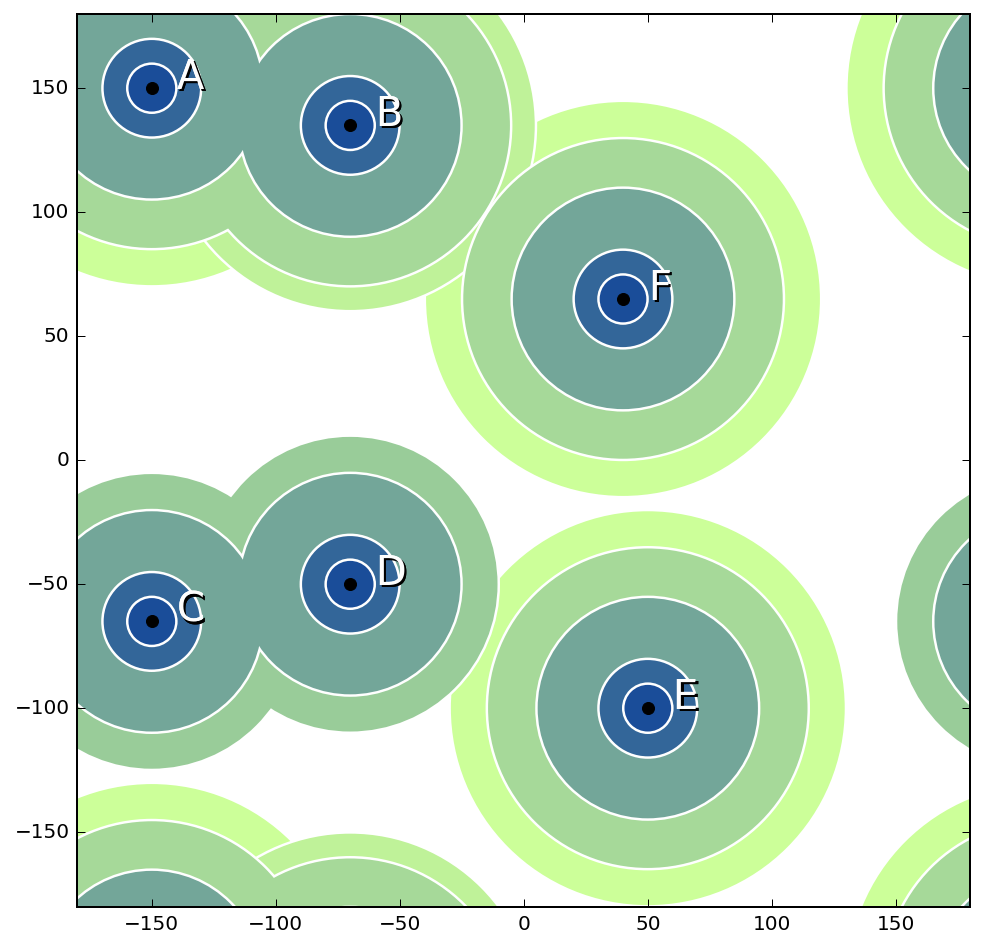

In [41]:
plot_main()
for tr in storage.trajectories:
    if all(map(vol_state['B'], tr[[0,-1]])):
        plot_traj(tr, line=True)

In [42]:
mstis = paths.MSTISNetwork([
    (
        vol_state[state],
        interface_list[state][0:],
        cv_state[state]
    ) for state in states
])

In [43]:
storage.save(mstis)

(store.networks[TransitionNetwork], 14, 0)

In [44]:
initial_bootstrap = dict()

In [45]:
for state in states:
    while state not in initial_bootstrap:
        try:
            paths.tools.refresh_output(
                'Bootstrapping state ' + state
            )            
            from_state = vol_state[state]
            bootstrapA = paths.FullBootstrapping(
                transition=mstis.from_state[from_state],
                snapshot=random.choice(initials[state]),
                engine=engine,
                extra_interfaces=[interface_list[state][-1]],
                initial_max_length=20      
            )
            paths.tools.refresh_output(
                'Bootstrapping state ' + state + " - let's go"
            )            
            final = bootstrapA.run(max_ensemble_rounds=2, build_attempts=5)
            if all([s.ensemble(s) for s in final]):
                initial_bootstrap[state] = final
        except ValueError:
            paths.tools.refresh_output(
                'Encountered NaN'
            )
        except RuntimeError:
            paths.tools.refresh_output(
                'Too many attempts. Start retry.'
            )

paths.tools.refresh_output(
    'DONE!'
)

In [46]:
total_sample_set = paths.SampleSet.relabel_replicas_per_ensemble(
    initial_bootstrap.values()
)

In [47]:
total_sample_set.sanity_check()

In [48]:
storage.save(total_sample_set)
storage.sync_all()

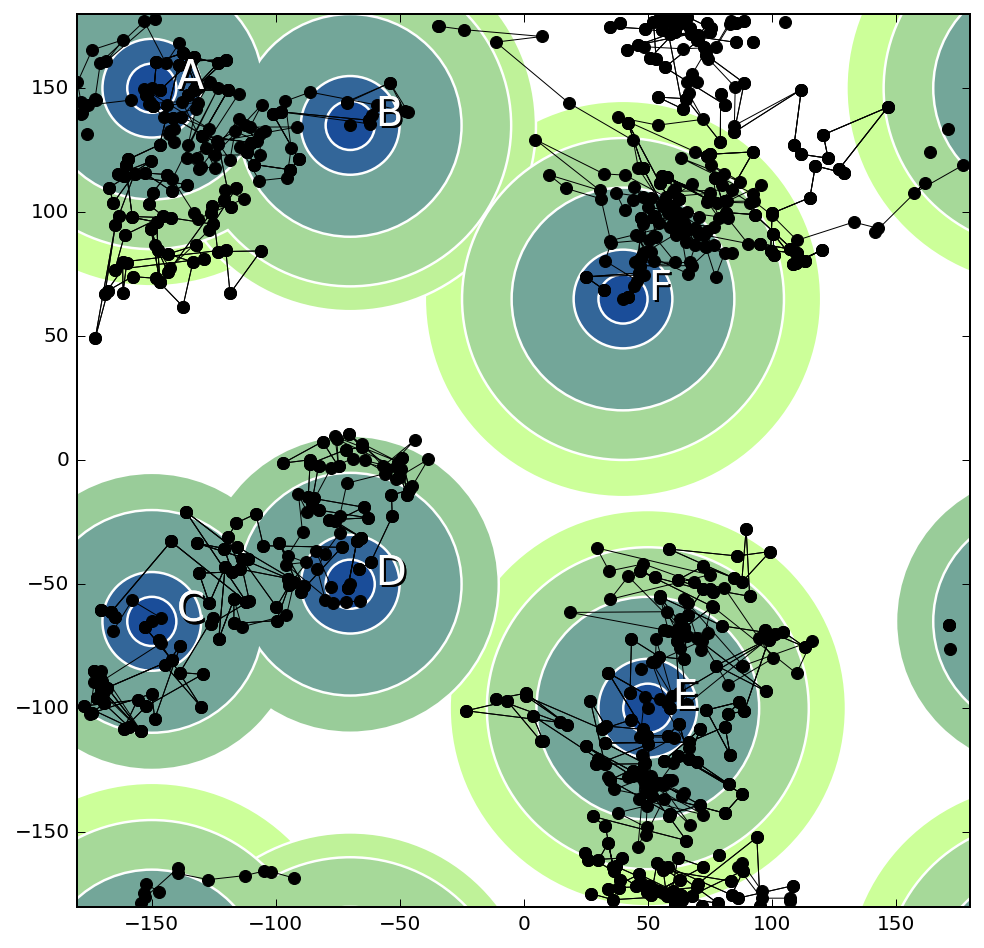

In [49]:
plot_main()
for s in total_sample_set:
    plot_traj(s.trajectory, line=True)

In [50]:
len(total_sample_set)

28

In [51]:
storage.close()